In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pickle
try:
    import pymc as pymc3
except:
    import pymc3

import calibr8
import cutisplit
import pyrff
import retl
import robotools
import scipy

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc 4.0.0
calibr8 6.1.0


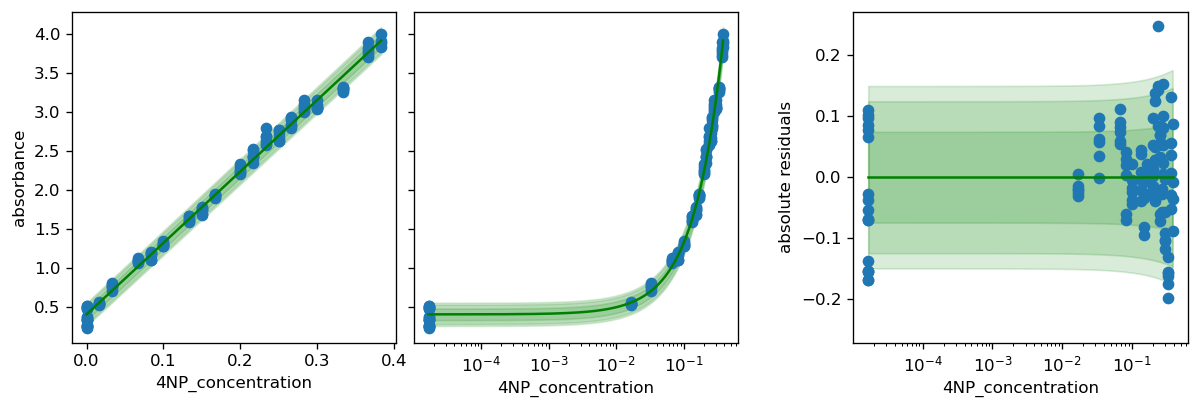

In [8]:
RUN_ID = "C8NNMA"
resultpath = f'{RUN_ID}_Results' 
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol)


df_inputs, df_kinetics = run_analysis.read_rounds(["C8NNMA"])

## Creating the Model

In [9]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

strain              (24,)	AbnA, AmyE, AprE, …, YwmC
culture_id          (24,)	C8NNMA_B02, C8NNMA_B03, C8NNMA_B04, …, C8NNMA_E07
kinetic_id          (96,)	C8NNMA_1_B02, C8NNMA_1_B03, C8NNMA_1_B04, …, C8NNMA_2_G11
column_id           (8,)	2, 3, 4, …, 11
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

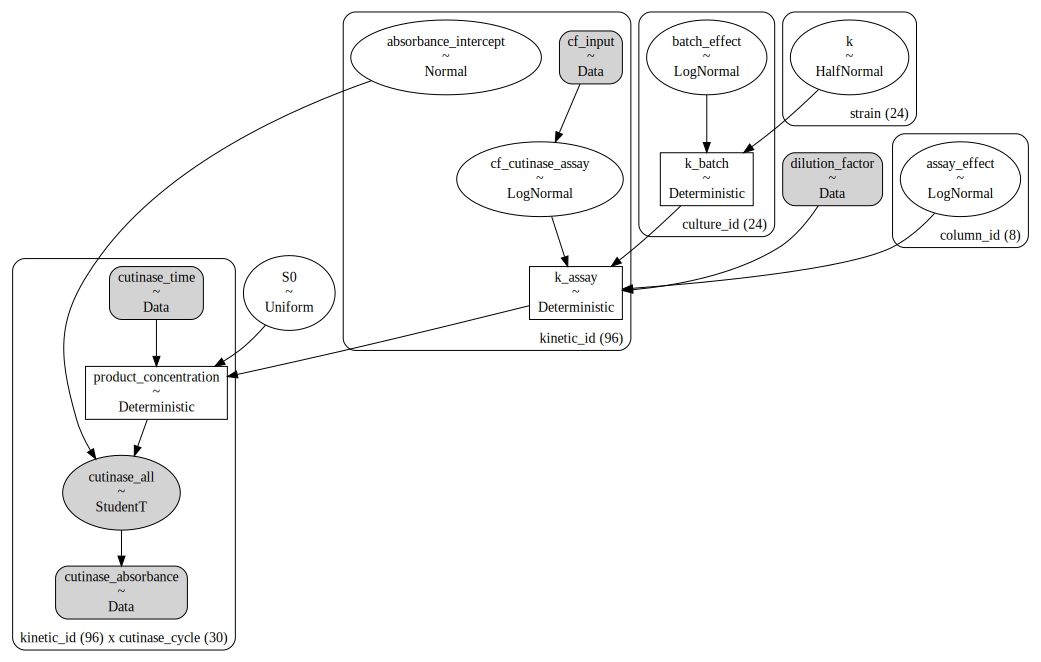

In [10]:
pymc3.model_to_graphviz(model.pmodel)

In [12]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cf_cutinase_assay, k, batch_effect, assay_effect, S0, absorbance_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 354 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [13]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_columneffect.nc")

'C8NNMA_Results\\C8NNMA_result_columneffect.nc'

Execute the next cell in case you want to reload saved data

In [27]:
idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result_hierarchical_non_centered.nc")

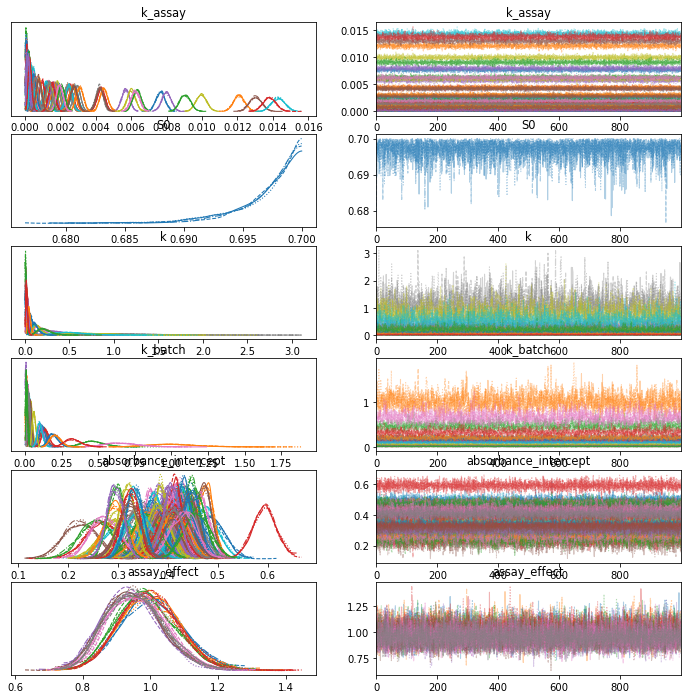

In [14]:
arviz.plot_trace(idata, var_names=[
    "k_assay", "S0", "k", "k_batch", "absorbance_intercept", "assay_effect"
]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.1\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (144) is smaller than the number of resulting pair plots with these variables, generating only a 16x16 grid
  warnings.warn(


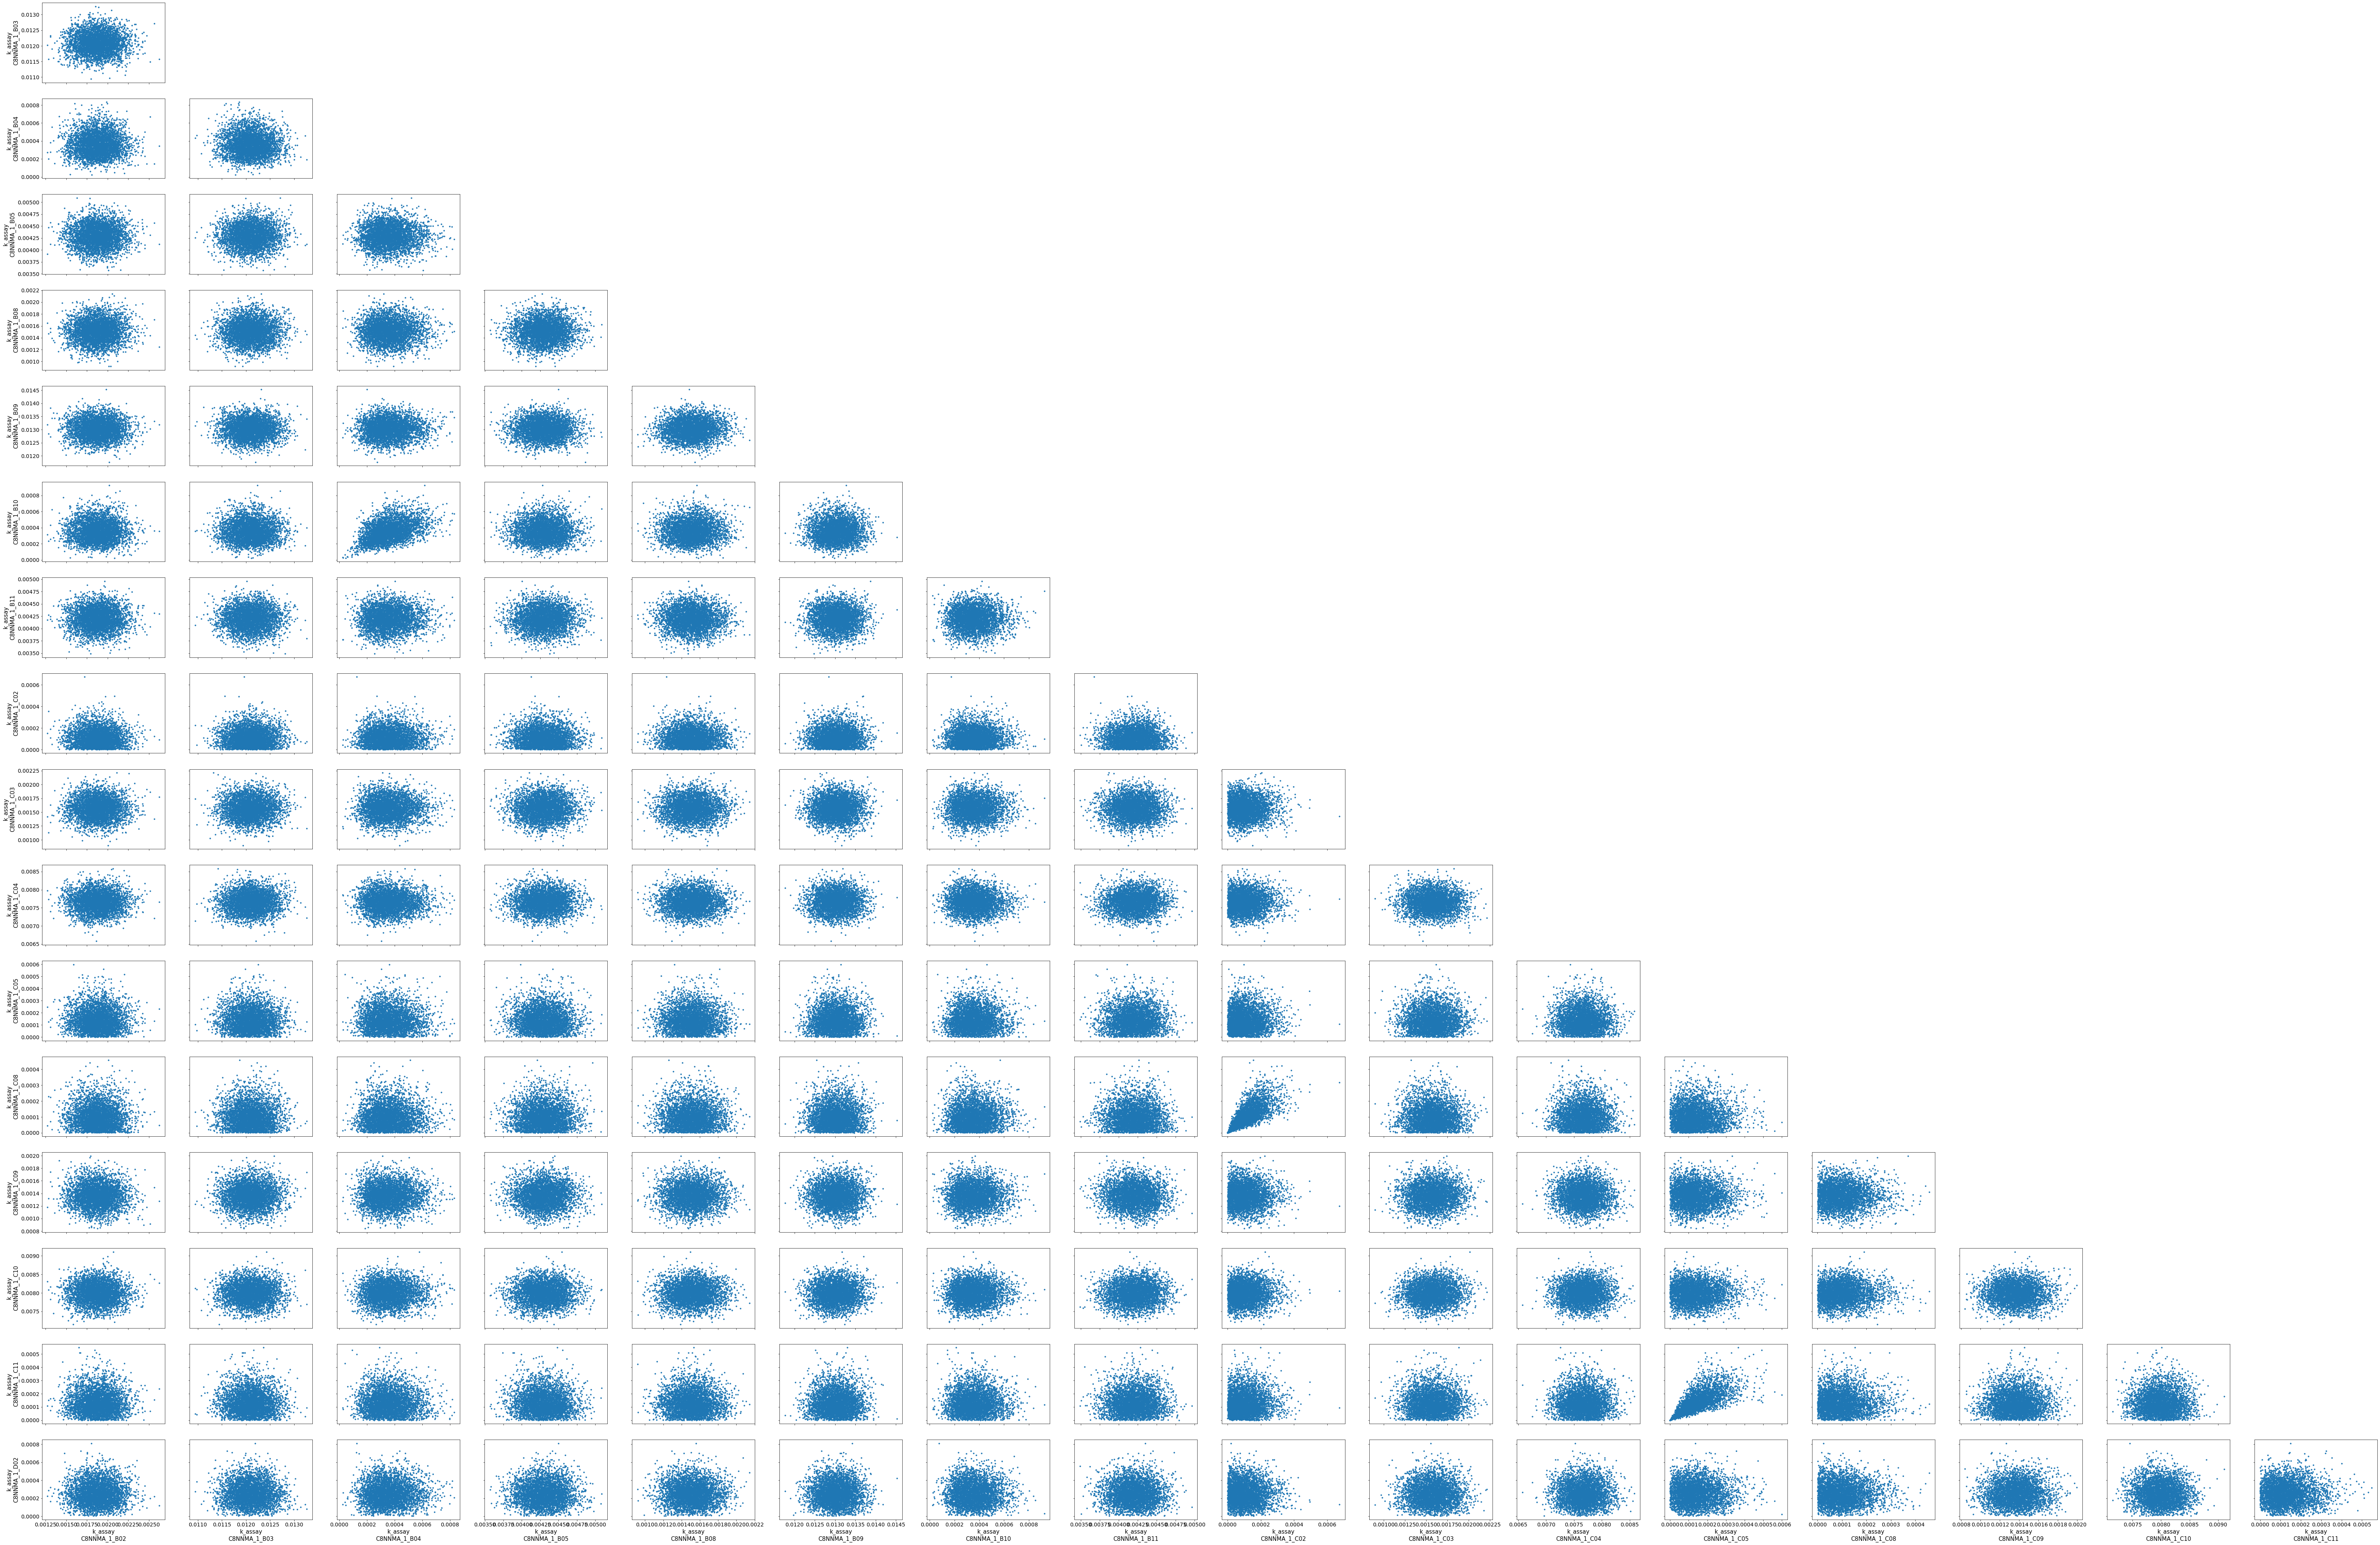

In [15]:
arviz.rcParams['plot.max_subplots'] = 144
arviz.plot_pair(idata, var_names=[
    "k_assay", 
    "k", "k_batch", "S0", 
    "absorbance_intercept"
]);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

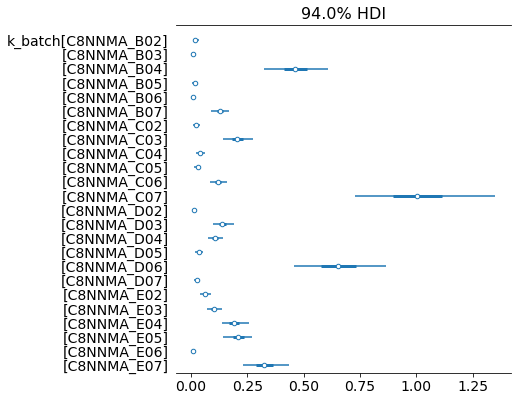

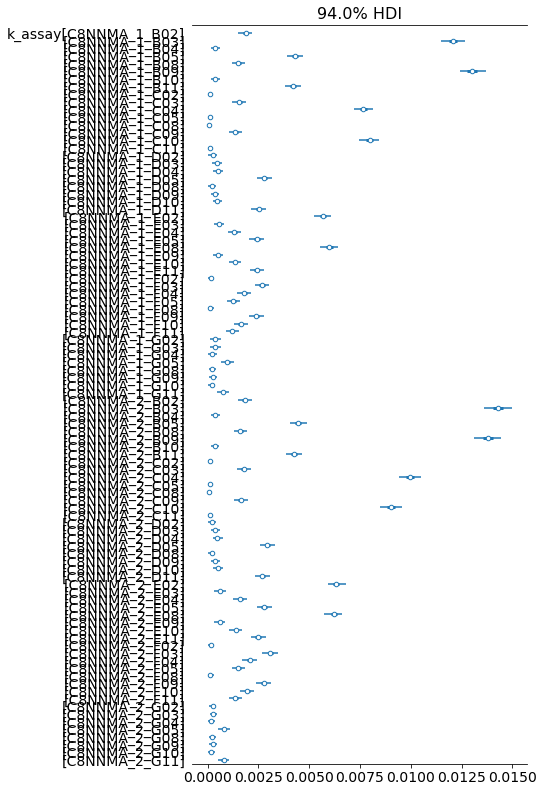

In [16]:
arviz.plot_forest(idata, var_names=["k_batch"], combined=True)
arviz.plot_forest(idata, var_names=["k_assay"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

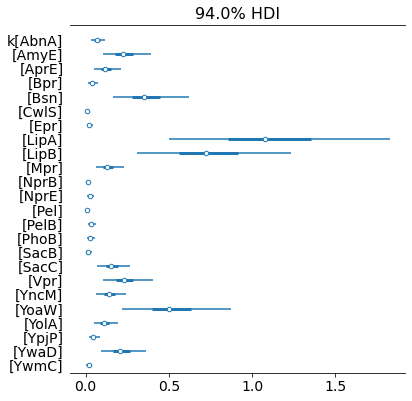

In [17]:
arviz.plot_forest(idata, var_names=["k"], combined=True)

In [18]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior

<xarray.Dataset>
Dimensions:                (column_id: 8, culture_id: 24, cutinase_cycle: 30, kinetic_id: 96, sample: 4000, strain: 24)
Coordinates:
  * kinetic_id             (kinetic_id) <U12 'C8NNMA_1_B02' ... 'C8NNMA_2_G11'
  * strain                 (strain) <U4 'AbnA' 'AmyE' 'AprE' ... 'YwaD' 'YwmC'
  * culture_id             (culture_id) <U10 'C8NNMA_B02' ... 'C8NNMA_E07'
  * column_id              (column_id) int32 2 3 4 5 8 9 10 11
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (kinetic_id, sample) float64 1.183 1.25 ... 1.223
    k                      (strain, sample) float64 0.1164 0.1532 ... 0.018
    batch_effect           (culture_id, sample) float64 1.592 1.218 ... 1.188
    assay_effect           (column_id, sample) float64 0.9454 1.051 ... 0.7948
    S0                     (sample) float64 0.6976 0.6896 ... 0.6973 0.6991
    absorbance_intercept   (kinetic_id, sample) float64 0.3936 0.4059 ... 0.3285
    k_batch                (culture_id, sample) float64 0.0328 0.03031 ... 0.392
    k_assay                (kinetic_id, sample) float64 0.002085 ... 0.0008503
    product_concentration  (kinetic_id, cutinase_cycle, sample) float64 0.0 ....
Attributes:
    created_at:                 2021-10-20T17:13:10.754338
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0
    sampling_time:              354.2719476222992
    tuning_steps:               1000

In [19]:
strains = numpy.unique(df_inputs.strain.values)
pyrff.sample_batch(
    posterior.k.values,
    ids=strains,
    batch_size=12,
    correlated=True
)

('LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA',
 'LipA')

In [20]:
probs = pyrff.sampling_probabilities(
    posterior.k.values,
    correlated=True
)

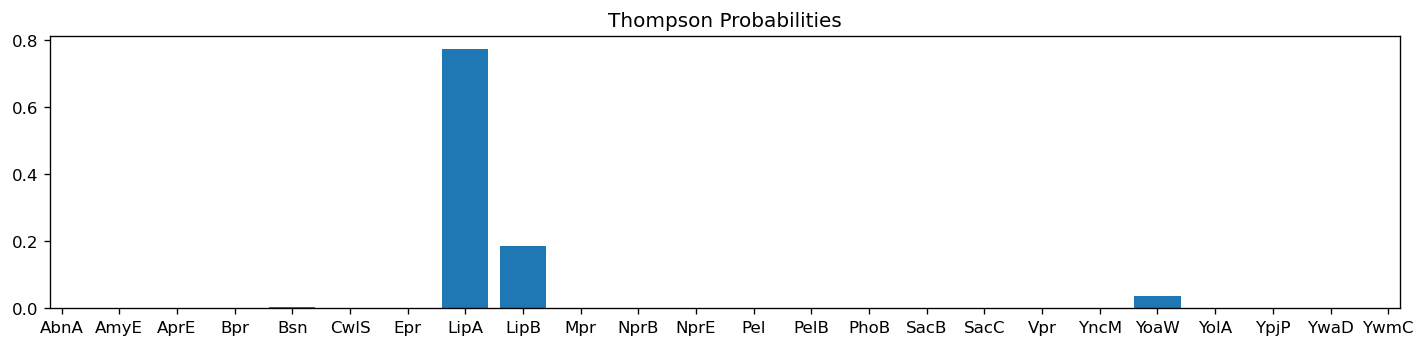

In [21]:
fig, ax = pyplot.subplots(figsize=(12,3), dpi=120)
ax.bar(x=numpy.arange(len(probs)), height=probs,)
ax.set(
    xticks=numpy.arange(len(probs)), 
    xticklabels=numpy.unique(df_inputs.strain.values),
    xlim=(-0.2,23.2),
)
ax.set_title("Thompson Probabilities")
pyplot.tight_layout()

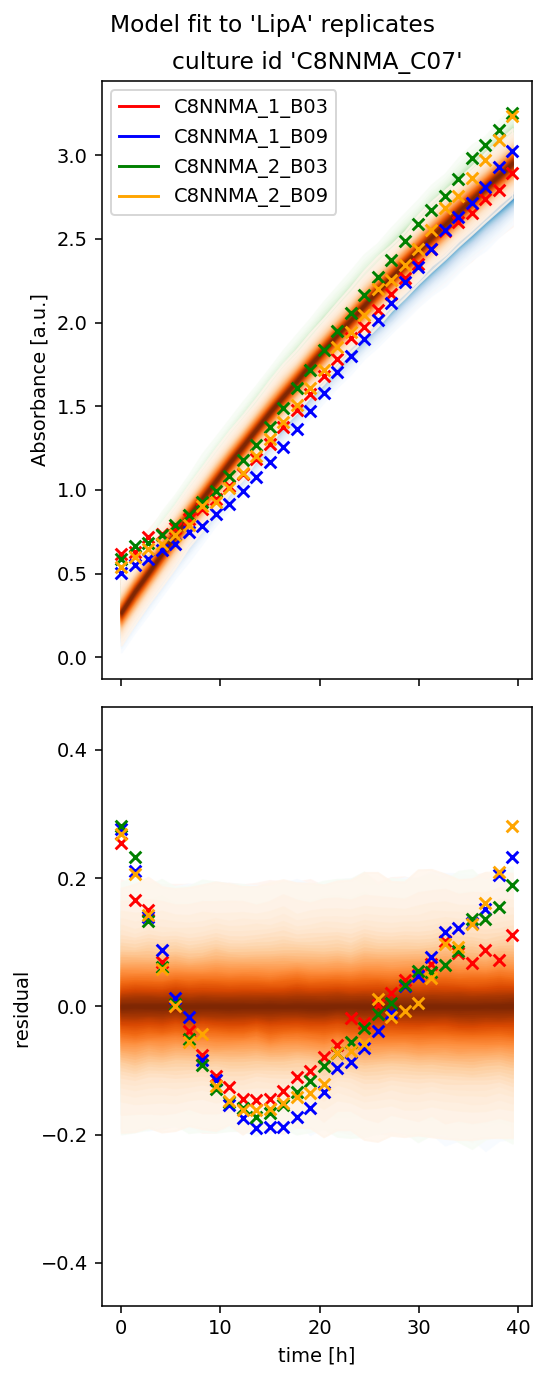

In [24]:
#for strain in posterior.strains.values:
strain="LipA"
culture_ids = df_inputs[df_inputs.strain==strain].index.to_list()
fig, axs = pyplot.subplots(
        dpi=140,
        figsize=( 4*len(culture_ids), 10),
        ncols=len(culture_ids),
        nrows=2,
        sharey="row",
        sharex="col",
        squeeze=False,
    )
for c, cid in enumerate(culture_ids):
    df = df_kinetics[df_kinetics.culture_id==cid]
    kinetic_ids = df.index
    residual_ptp = 0
    for r, (kid, (color, cmap)) in enumerate(zip(kinetic_ids, [
        ("red", "Reds"),
        ("blue", "Blues"),
        ("green", "Greens"),
        ("orange", "Oranges"),
    ])):


        # and the actual absorbance
        absorbance = idata.constant_data.cutinase_absorbance.sel(kinetic_id=kid)
        #print(color, kid, cid)
        
        axs[0,c].scatter(
            idata.constant_data.cutinase_time.values[0,:],
            absorbance,
            marker="x",
            color=color,
            zorder=10
        )
        theta = [
            posterior.absorbance_intercept.sel(kinetic_id=kid).values
        ] + list(cm_nitrophenol.theta_fitted[1:])
        loc, scale, df = cm_nitrophenol.predict_dependent(
            posterior.product_concentration.sel(kinetic_id=kid).values,
            theta=theta
            
        )
        pp_samples = scipy.stats.t.rvs(loc=loc, scale=scale, df=df)

        pymc3.gp.util.plot_gp_dist(
            ax=axs[0,c],
            samples=pp_samples.T,
            x=idata.constant_data.cutinase_time.values[0,:],
            palette=cmap,
            plot_samples=False,
        )
        
        #residuals
        median = numpy.median(pp_samples, axis=1)
        residuals = absorbance.values - median
        residual_ptp = max(residual_ptp, numpy.ptp(residuals))

        pymc3.gp.util.plot_gp_dist(
            ax=axs[1, c],
            samples=(pp_samples - median[:,None]).T,
            x=idata.constant_data.cutinase_time.values[0,:],
            plot_samples=False,
            palette=cmap
        )
        axs[1, c].scatter(
            idata.constant_data.cutinase_time.values[0,:], residuals, marker="x", color=color, zorder=10
        )
        axs[0, c].plot([], [], color=color, label=kid)
    # formatting
    axs[0, c].set_title(f"culture id '{cid}'")
    axs[1, c].set_xlabel("time [h]") 
    axs[0, c].legend()

axs[0, 0].set_ylabel(
    "Absorbance [a.u.]"
)
axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
axs[1, 0].set_ylabel("residual ")
fig.suptitle(
    f"Model fit to '{strain}' replicates"
)
fig.tight_layout()

Check Hill kinetics

In [ ]:
import murefi

In [ ]:
class HillModel(murefi.BaseODEModel):
    """ Class specifying the model for parameter fitting as Hill kinetics. """

    def __init__(self):
        self.bounds = dict(
            S_0=(0.5,0.8),
            X_0=(0.001,0.02),
            mue_max=(0.01,5),
            K_S=(0.00005,0.05),
            Y_XS=(0.01,5),
            n=(0.001, 100)
        )
        self.initial_guesses = dict(
            S_0=0.6,
            X_0=0.1,
            mue_max=0.3,
            K_S=0.02,
            Y_XS=0.45,
            n=1
        )
        super().__init__(parameter_names=('S0', 'X0', 'mu_max', 'K_S', 'Y_XS', 'n'), independent_keys=['S', 'X'])

    def dydt(self, y, t, theta):
        """First derivative of the transient variables.
        Args:
            y (array): array of observables
            t (float): time since intial state
            theta (array): Monod parameters
        Returns:
            array: change in y at time t
        """
        # NOTE: this method has significant performance impact!
        S, X = y
        mu_max, K_S, Y_XS, n = theta
        dXdt = mu_max * numpy.power(S,n) * X / (K_S + numpy.power(S, n))
    
        yprime = [
            -1/Y_XS * dXdt,
            dXdt,
        ]
        return yprime


In [ ]:
independent = df_kinetics.loc["BZACW9_1_D10"].time
dependent = df_kinetics.loc["BZACW9_1_D10"].value
ds = murefi.Dataset()
ts = murefi.Timeseries(independent, dependent, independent_key="X", dependent_key="absorbance")
rep = murefi.Replicate(rid="LipA")
rep["absorbance"] = ts
ds["LipA"] = rep

model = HillModel()

mapping_df = pandas.DataFrame(columns=['rid', 'S0', 'X0', 'mu_max', 'K_S', 'Y_XS', 'n'])
new_row = pandas.Series(
    (
        "LipA",
        'S_0', 
        'X_0',
        'mue_max', 
        'K_S',
        'Y_XS',
        'n'
    ),
    index=mapping_df.columns
)
mapping_df = mapping_df.append(new_row, ignore_index=True).set_index("rid")
mapping = murefi.ParameterMapping(mapping_df, bounds=model.bounds, guesses=model.initial_guesses)

In [ ]:
import scipy.optimize
obj = murefi.objectives.for_dataset(ds, model, mapping, calibration_models=[cm_nitrophenol])
fit_mle = scipy.optimize.minimize(
    obj,
    mapping.guesses, 
    bounds=mapping.bounds
)
fit_mle_dict = {
    pname : float(v)
    for pname, v in zip(mapping.parameters, fit_mle.x)
}

In [20]:
ds_pred = model.predict_dataset(ds, parameter_mapping=mapping, parameters=fit_mle_dict)

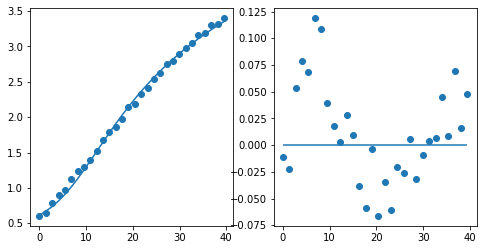

In [21]:
fig, axs = pyplot.subplots(figsize=(8,4), ncols=2)
axs[0].scatter(independent, dependent)
mu, _, _ = cm_nitrophenol.predict_dependent(ds_pred["LipA"]["absorbance"].y)
axs[0].plot(
    ds_pred["LipA"]["absorbance"].t,
    mu
)
axs[1].scatter(independent, dependent-mu)
axs[1].hlines(0, xmin=min(independent), xmax=max(independent))

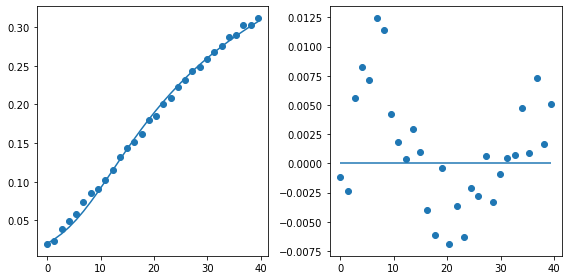

In [22]:
fig, axs = pyplot.subplots(figsize=(8,4), ncols=2)

mu = cm_nitrophenol.predict_independent(dependent)
axs[0].scatter(independent, mu)
axs[0].plot(
    ds_pred["LipA"]["absorbance"].t,
    ds_pred["LipA"]["absorbance"].y
)
axs[1].scatter(independent, mu-ds_pred["LipA"]["absorbance"].y)
axs[1].hlines(0, xmin=min(independent), xmax=max(independent))
pyplot.tight_layout()